## Dependencies

In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
# Initialize the library.
ee.Initialize()

## Configuration

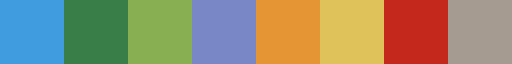

In [3]:
from matplotlib.colors import ListedColormap
LABEL_DICT = {'built': 6, 'water': 0, 'tree': 1, 'grass': 2, 'flooded_veg': 3, 'crop': 4, 
             'shrub': 5, 'bare': 7}#, 'snow': 8}
LABEL_DICT_REV = {k:v for (v,k) in LABEL_DICT.items()}
COLOR_DICT = {'built': '#C4281B', 'water': '#419BDF', 'tree': '#397D49', 'grass': '#88B053', 
              'flooded_veg': '#7A87C6', 'crop': '#E49635', 
             'shrub': '#DFC35A', 'bare': '#A59B8F'}#, 'snow': '#B39FE1'}
COLOR_DICT_REV = {}

for k in LABEL_DICT.keys():
    COLOR_DICT_REV[LABEL_DICT[k]] = COLOR_DICT[k]
 
c = []
for i in range(8):
    c.append(COLOR_DICT_REV[i])

cmap = ListedColormap(c)
cmap

In [4]:
csv_file = './DBR_Excel_data_pro.csv'

## Load bridge info

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df_2016 = df.drop(df[df.start_year < 2016].index)
df_2019 = df[df.start_year == 2019]

In [15]:
df_2019.shape

(301, 21)

take one bridge as example

In [8]:
df_2016.iloc[324]

Unnamed: 0                        6320
S.No                              6321
Bridge_No            25 5 003 18 06 04
Bridge_Name                Ghuselbensi
Bridge_Type                          D
Bridge_Span                         90
River_Name                     Bagmati
Trail_Type                       Local
District                      Lalitpur
Major_VDC                       Ghusel
Major Palika                       NaN
State                                3
Ward_No                              3
Latitude                      27.52772
Longitude                    85.251052
Const_Year                   2016/2017
Local_Fund                         GoN
Foreign_Agency                     NaN
Bridge Condition    No action required
start_year                        2016
end_year                          2017
Name: 4590, dtype: object

In [9]:
bridge = df_2016.iloc[324]

## Convert/download class map as array

* randomly pick one dynamic world fullfill the filter criterias
* return its class map as array (for further analysis & visualization)

In [10]:
def getArray(lon, lat, year, distance=1000):
    # create point
    point = ee.Geometry.Point(lon, lat)
    
    # create buffer as geometry
    geometry = point.buffer(distance=distance)
    
    # define time range (annual)
    startDate = '{}-01-01'.format(year)
    endDate = '{}-01-01'.format(int(year)+1)
    
    # select S2 and corresponding DW
    s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterDate(startDate, endDate).filterBounds(geometry).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35))
    s2Image = ee.Image(s2.first())
    imageId = s2Image.get('system:index').getInfo()
    dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.eq('system:index', imageId))
    dwImage = ee.Image(dw.first())
    classification = dwImage.select('label')
    
    # convert to np.array
    rgb_arr = geemap.ee_to_numpy(classification, region=geometry)
    #rgb_arr = np.max(rgb_arr, axis=2) #dropping third dimension
    return rgb_arr, {'imageId':imageId, 'longitude':lon, 'latitude': lat, 'distance': distance}

In [11]:
def getAnnualFraction(lon, lat, year, label='built', distance=1000):
    # create point
    point = ee.Geometry.Point(lon, lat)
    
    # create buffer as geometry
    geometry = point.buffer(distance=distance)
    
    # define time range (annual)
    startDate = '{}-01-01'.format(year)
    endDate = '{}-01-01'.format(int(year)+1)
    
    label_idx = LABEL_DICT[label]
    #print('generate {} fraction for year {} at ({}, {})'.format(label, year, lon, lat))
    
    # get annual composite Dynamic World Product

    dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(startDate, endDate).filterBounds(geometry)
    classification = dw.select('label')
    dwComposite = classification.reduce(ee.Reducer.mode())
    
    # compute fraction
    area = dwComposite.eq(label_idx)
    dwComposite = dwComposite.rename(['classification'])
    area = area.rename([label])
    
    # Count all pixels.
    statsTotal = area.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=geometry,
        scale=10,
        maxPixels=1e10
        )
    totalPixels = statsTotal.get(label).getInfo()

    # Mask 0 pixel values and count remaining pixels.
    areaMasked = area.selfMask()

    statsMasked = areaMasked.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=geometry,
        scale=10,
        maxPixels=1e10
        )
    areaPixels = statsMasked.get(label).getInfo()
    
    fraction = areaPixels/totalPixels

    return totalPixels, areaPixels, fraction

In [12]:
lat, lon = bridge['Latitude'], bridge['Longitude']
start_year, end_year = bridge['start_year'], bridge['end_year']

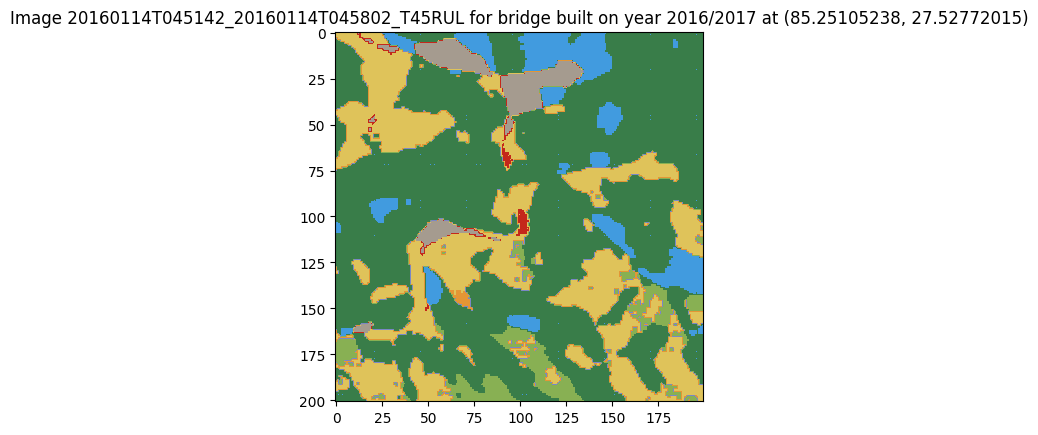

In [13]:
rgb_img, info = getArray(lon, lat, start_year)
plt.imshow(rgb_img, cmap=cmap)
plt.title('Image {} for bridge built on year {} at ({}, {})'.format(info['imageId'], bridge['Const_Year'], bridge['Longitude'], bridge['Latitude']))
plt.show()

In [17]:
stats_df = defaultdict(lambda: defaultdict(list))

missing = [18, 157,156, 192, 223, 248, 252, 281, 284]

for i in range(301):

    if i in missing:
        continue

    bridge = df_2019.iloc[i]
    lat, lon = bridge['Latitude'], bridge['Longitude']
    start_year, end_year = bridge['start_year'], bridge['end_year']

    for y in range(2022, 2023):
        for l in LABEL_DICT:
            totalPixels, areaPixels, fraction = getAnnualFraction(lon, lat, y, l, distance=1000)
            stats_df[y][l].append(areaPixels)
        stats_df[y]["year"].append(y)
        stats_df[y]["bridgeId"].append(i)
        stats_df[y]["totalPixels"].append(totalPixels)
        stats_df[y]["Latitude"].append(lat)
        stats_df[y]["S.No"].append(bridge['S.No'])
        stats_df[y]["Longitude"].append(lon)
        stats_df[y]["start_year"].append(start_year)
        stats_df[y]["end_year"].append(end_year)
    print(i) 
    # faulty indices (df_2019): 
    # [18, 157] (Image.eq: If one image has no bands, the other must also have no bands. Got 0 and 1) 
    # [156, 192, 223, 248, 252, 281, 284] -> ZeroDivisionError: division by zero (totalPixels = 0)

In [ ]:
i

284

## concatenating DFs

In [ ]:
data = pd.DataFrame.from_dict(stats_df[2016])

for y in range(2017,2023):
    data = pd.concat([data, pd.DataFrame.from_dict(stats_df[y])], ignore_index=True)
    

## Exporting data

In [ ]:
from pathlib import Path  
filepath = Path('./df_2019/out10.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath)  

## Time-Series inspector

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

point = ee.Geometry.Point(lon, lat)
    
# creat buffer as geometry
geometry = point.buffer(distance=1000)
year = bridge['start_year']
startDate = '{}-01-01'.format(year)
endDate = '{}-01-01'.format(int(year)+1)

Map.centerObject(geometry)

images = geemap.dynamic_world_timeseries(
    geometry, startDate, "2022-01-01", return_type="hillshade"
)
"""rgbVis = {"bands": ['B11', 'B8', 'B3'],"min": 0,"max": 3000}
imageCol = ee.ImageCollection('COPERNICUS/S2_SR');
Map.addLayer(imageCol, rgbVis, 'ImageCollection mosaic');"""

Map.ts_inspector(images, date_format='YYYY')
Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Dropdown(layout=Lay…